<a href="https://colab.research.google.com/github/bbchen33/Deep-learning/blob/master/Flower_images_w_SparkDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!sudo apt install openjdk-8-jdk
!sudo update-alternatives --config java

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk is already the newest version (8u222-b10-1ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.
There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
  0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
* 2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2


In [11]:
!java -version

openjdk version "1.8.0_222"
OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1ubuntu1~18.04.1-b10)
OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)


In [13]:
!pip install pyspark

In [15]:
!curl -O http://download.tensorflow.org/example_images/flower_photos.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  53.5M      0  0:00:04  0:00:04 --:--:-- 53.5M


In [0]:
!tar xzf flower_photos.tgz

In [17]:
!ls

flower_photos  flower_photos.tgz  sample_data


In [7]:
!ls -l flower_photos

total 624
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  53248 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  49152 Feb 10  2016 tulips


Count number of files in each folder.

In [18]:
!ls flower_photos/daisy | wc -l

633


In [19]:
!ls flower_photos/tulips | wc -l

799


In [21]:
!ls flower_photos/roses | wc -l

641


Use IPython display to show the images

In [0]:
import IPython.display as dp
daisy_photos = !ls flower_photos/daisy/*.jpg
images = []
for pics in daisy_photos:
  images.append(dp.Image(filename = pics, format = 'png'))



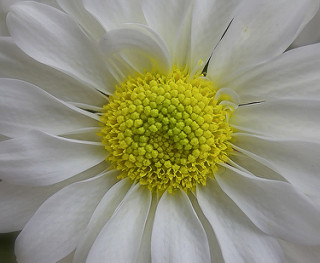

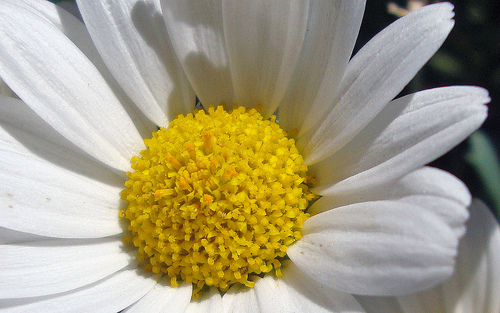

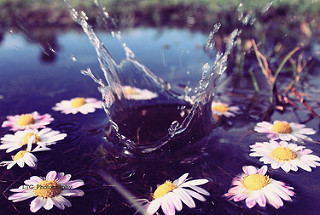

In [24]:
for img in images[:3]:
  dp.display_png(img)

Alternatively, use Pillow to open to image.

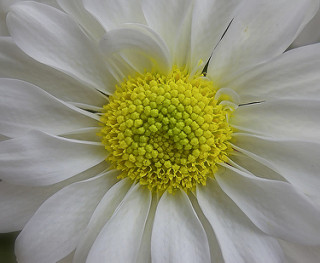

In [119]:
from PIL import Image
Image.open(daisy_photos[0])

Using Spark Deep Learning library to perform machine learning

In [28]:
!pip install sparkdl

In [0]:
from pyspark.ml.image import ImageSchema

Read the images with ImageSchema and add a column for the label for machine learning training.

In [0]:
from pyspark.sql.functions import lit
tulips_df = ImageSchema.readImages("flower_photos/tulips").withColumn('label', lit(1))

In [50]:
tulips_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: integer (nullable = false)



I've tried to use ImageSchema from pyspark.ml.image to load the images. It gave me problems when I tried to train the images so I had to load the data with Pillow and Numpy.

In [0]:
import pandas as pd
df = pd.DataFrame(columns = ['tulip', 'rose','sunflower'])

In [0]:
from os import listdir
def load_images(flower_name):
  path_name = ('flower_photos/{}/'.format(flower_name))
  img = []
  for pic in listdir(path_name):
    img.append(np.asarray(Image.open('flower_photos/{}/{}'.format(flower_name, pic)), dtype = 'int32'))  
  return img

In [0]:
load = load_images('tulips')

In [166]:
len(load)

799

The number of tulip samples is consistnet with the number of files in the tulip folder. 

In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter = 10, featuresCol = 'image', regParam = 0.03, elasticNetParam = 0.5, labelCol = 'label')